In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

In [48]:
dir_dataset = "datasety/"
train_x = np.load(dir_dataset + 'train_x.npy')
train_y = np.load(dir_dataset + 'train_y.npy')

test_x = np.load(dir_dataset + 'test_x.npy')
test_y = np.load(dir_dataset + 'test_y.npy')

In [49]:
# from random import shuffle
# ind = [i for i in range(len(train_y))]
# shuffle(ind)
# train_x = train_x[ind]
# train_y = train_y[ind]

In [50]:
# print(train_x.shape)
# print(train_y.shape)

In [51]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F

In [52]:
class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((2,))
        label_temp[label] = 1
        return torch.tensor(cv2.resize(image.T, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)).T, torch.tensor(label_temp)

In [53]:
from torch.utils.data import DataLoader
training_data = NCarsImageDataset("./Datasety/train_EST")
test_data = NCarsImageDataset("./Datasety/test_EST")



In [54]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [55]:
from torch import nn

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return F.hardtanh(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)

                del images, labels, outputs

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, loss.item(), (float(correct))/total))


            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool.pt")

                print('Accuracy of the network: {} %'.format( 100 * correct / total))

In [57]:
# creating the model

model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 10).to("cuda")


In [58]:
img, label = next(iter(train_dataloader))

In [59]:
print(img.shape)

torch.Size([32, 10, 224, 224])


tensor([1., 0.], dtype=torch.float64)


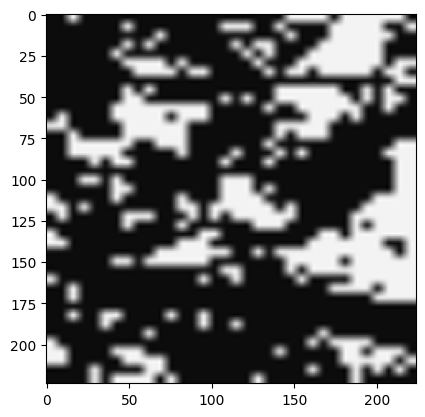

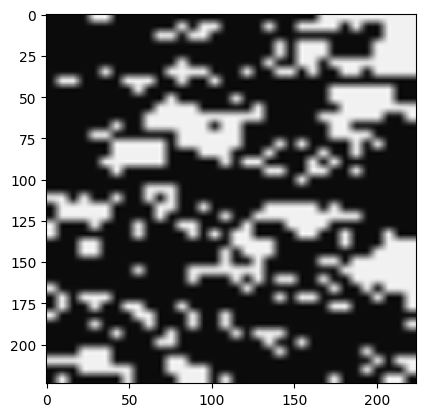

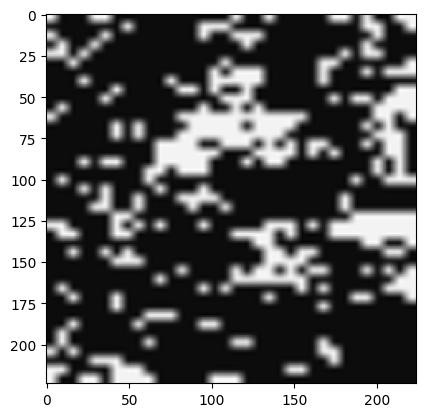

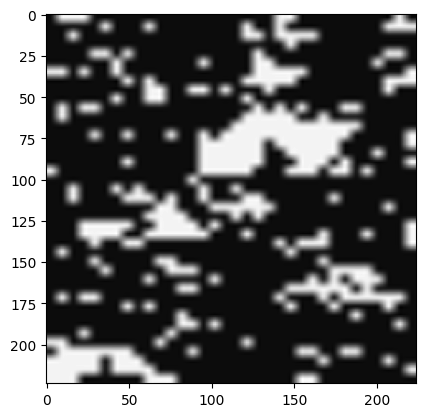

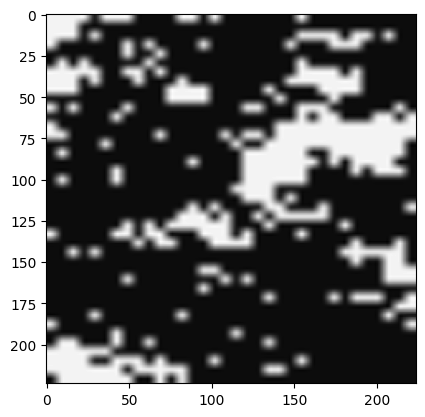

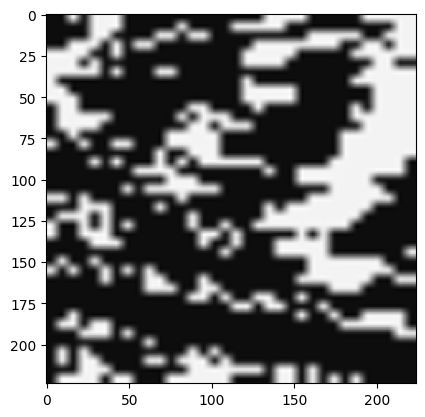

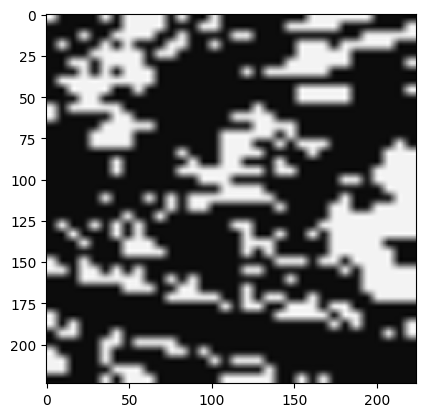

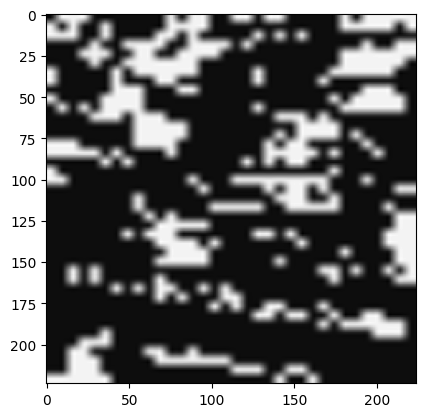

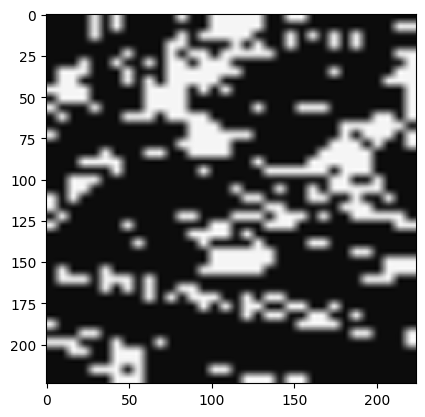

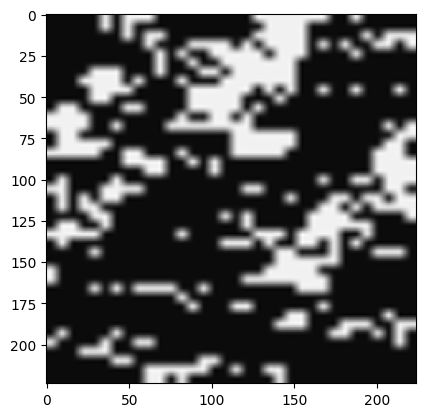

In [60]:
for j in range(1):
    print(label[j])
    for i in range(10):
        plt.imshow(img[j,i,:,:])
        plt.gray()
        
        plt.show()


In [61]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=10) #, learning_rate=5e-4

100%|██████████| 482/482 [02:37<00:00,  3.06it/s]


Epoch [1/10], Step [482/482], Loss: 0.4614, Accuracy: 0.7374
Accuracy of the network: 78.26187986522598 %


100%|██████████| 482/482 [02:24<00:00,  3.33it/s]


Epoch [2/10], Step [482/482], Loss: 0.3498, Accuracy: 0.8311
Accuracy of the network: 79.2262112234228 %


100%|██████████| 482/482 [02:26<00:00,  3.28it/s]


Epoch [3/10], Step [482/482], Loss: 0.6086, Accuracy: 0.8479
Accuracy of the network: 76.46102009991867 %


100%|██████████| 482/482 [02:28<00:00,  3.25it/s]


Epoch [4/10], Step [482/482], Loss: 0.3610, Accuracy: 0.8494
Accuracy of the network: 80.95736028813756 %


100%|██████████| 482/482 [02:27<00:00,  3.27it/s]


Epoch [5/10], Step [482/482], Loss: 0.3692, Accuracy: 0.8529
Accuracy of the network: 73.23109097246427 %


100%|██████████| 482/482 [02:25<00:00,  3.32it/s]


Epoch [6/10], Step [482/482], Loss: 0.2206, Accuracy: 0.8547
Accuracy of the network: 76.94899500406646 %


100%|██████████| 482/482 [02:24<00:00,  3.34it/s]


Epoch [7/10], Step [482/482], Loss: 0.4327, Accuracy: 0.8419
Accuracy of the network: 80.15568723132334 %


100%|██████████| 482/482 [02:25<00:00,  3.31it/s]


Epoch [8/10], Step [482/482], Loss: 0.4972, Accuracy: 0.8514
Accuracy of the network: 76.71662600209132 %


100%|██████████| 482/482 [02:25<00:00,  3.32it/s]


Epoch [9/10], Step [482/482], Loss: 0.3963, Accuracy: 0.8553
Accuracy of the network: 81.57313814337168 %


100%|██████████| 482/482 [02:25<00:00,  3.31it/s]


Epoch [10/10], Step [482/482], Loss: 0.3949, Accuracy: 0.8577
Accuracy of the network: 80.64366213547113 %


In [62]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=5, learning_rate=5e-4)

100%|██████████| 482/482 [02:23<00:00,  3.36it/s]


Epoch [1/5], Step [482/482], Loss: 0.3919, Accuracy: 0.8689
Accuracy of the network: 81.63123039386547 %


100%|██████████| 482/482 [02:23<00:00,  3.35it/s]


Epoch [2/5], Step [482/482], Loss: 0.2861, Accuracy: 0.8806
Accuracy of the network: 83.16486580690136 %


100%|██████████| 482/482 [02:25<00:00,  3.31it/s]


Epoch [3/5], Step [482/482], Loss: 0.2475, Accuracy: 0.8870
Accuracy of the network: 83.43209015917277 %


100%|██████████| 482/482 [02:25<00:00,  3.30it/s]


Epoch [4/5], Step [482/482], Loss: 0.2369, Accuracy: 0.8848
Accuracy of the network: 80.19054258161961 %


100%|██████████| 482/482 [02:26<00:00,  3.30it/s]


Epoch [5/5], Step [482/482], Loss: 0.3485, Accuracy: 0.8852
Accuracy of the network: 82.61879865225978 %


In [63]:
model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=5, learning_rate=1e-4)

100%|██████████| 482/482 [02:25<00:00,  3.31it/s]


Epoch [1/5], Step [482/482], Loss: 0.2948, Accuracy: 0.9100
Accuracy of the network: 84.11757871499942 %


100%|██████████| 482/482 [02:31<00:00,  3.17it/s]


Epoch [2/5], Step [482/482], Loss: 0.2449, Accuracy: 0.9201
Accuracy of the network: 84.39642151736959 %


100%|██████████| 482/482 [02:34<00:00,  3.11it/s]


Epoch [3/5], Step [482/482], Loss: 0.2398, Accuracy: 0.9212
Accuracy of the network: 84.41965841756709 %


100%|██████████| 482/482 [02:32<00:00,  3.17it/s]


Epoch [4/5], Step [482/482], Loss: 0.2057, Accuracy: 0.9226
Accuracy of the network: 84.18728941559196 %


100%|██████████| 482/482 [02:26<00:00,  3.29it/s]


Epoch [5/5], Step [482/482], Loss: 0.2925, Accuracy: 0.9226
Accuracy of the network: 85.09352852329499 %


In [67]:
torch.save(model_resnet, "best_resnet_nCars_Hardtanh_ReLUmaxpool.pt")

tensor([0., 1.], dtype=torch.float64)


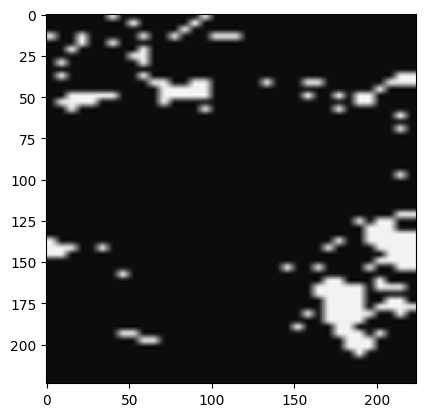

tensor([0., 1.], dtype=torch.float64)


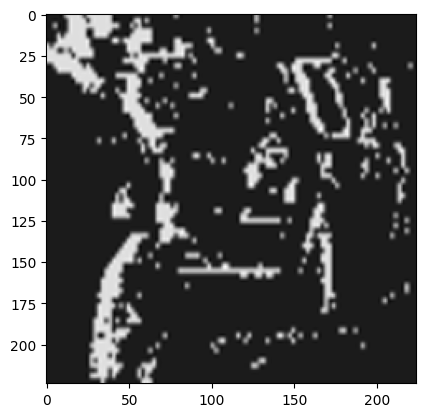

tensor([0., 1.], dtype=torch.float64)


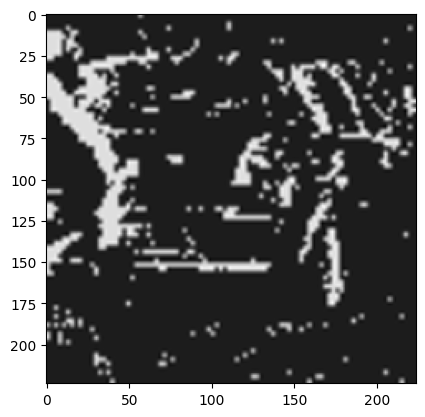

tensor([0., 1.], dtype=torch.float64)


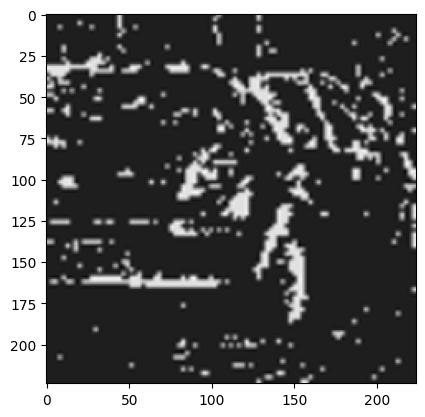

tensor([0., 1.], dtype=torch.float64)


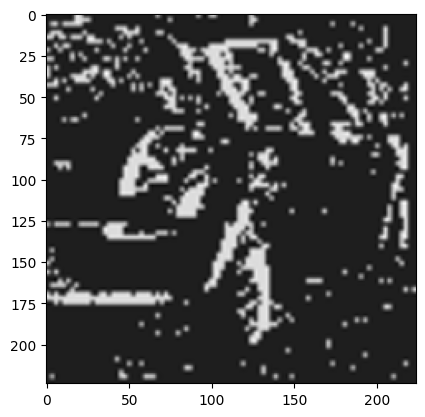

tensor([0., 1.], dtype=torch.float64)


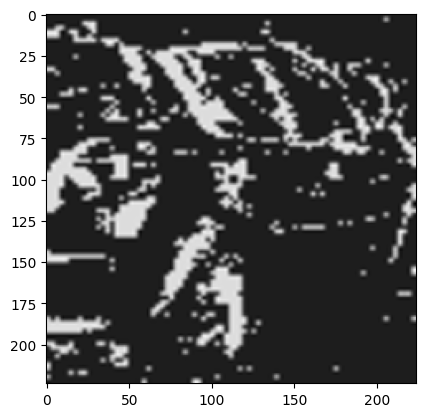

tensor([0., 1.], dtype=torch.float64)


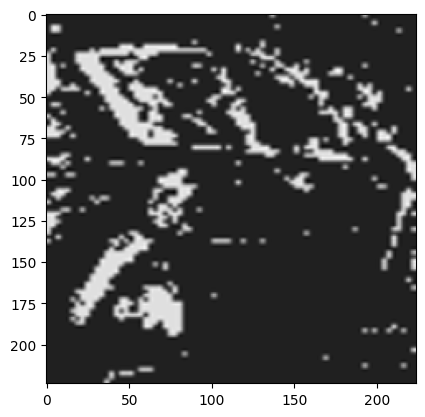

tensor([0., 1.], dtype=torch.float64)


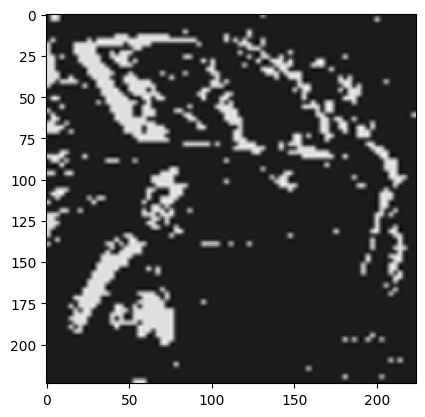

tensor([0., 1.], dtype=torch.float64)


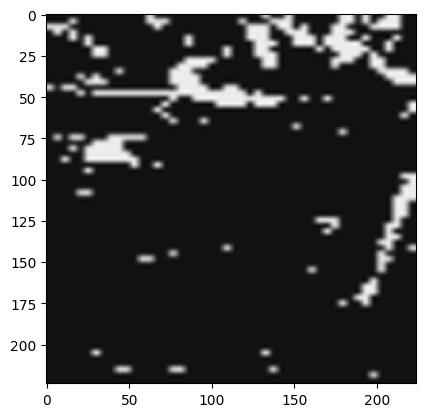

tensor([0., 1.], dtype=torch.float64)


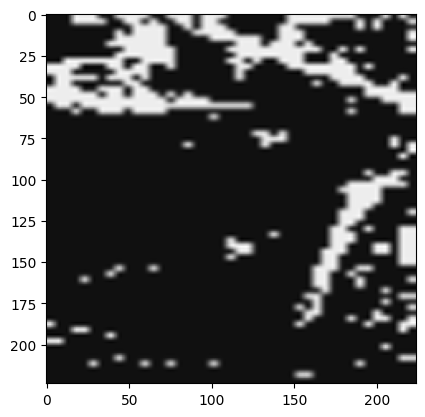

In [65]:
import matplotlib.pyplot as plt
for i in range(4000,4010):
    plt.imshow(train_dataloader.dataset[i][0][0,:,:])
    plt.gray()
    print(train_dataloader.dataset[i][1])
    plt.show()

1


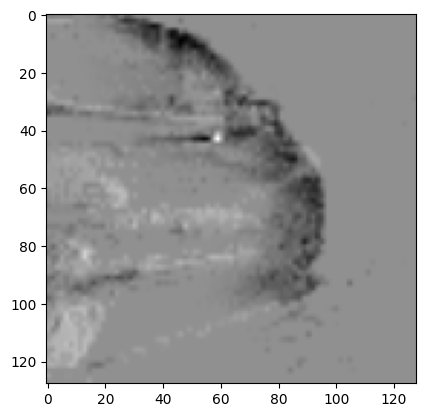

1


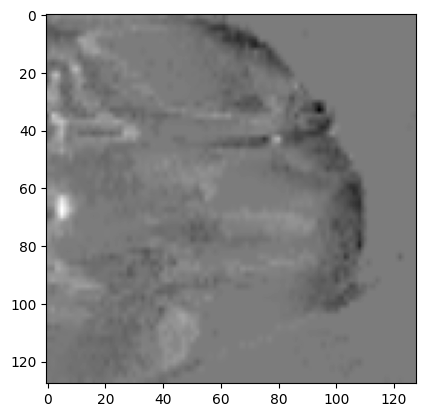

1


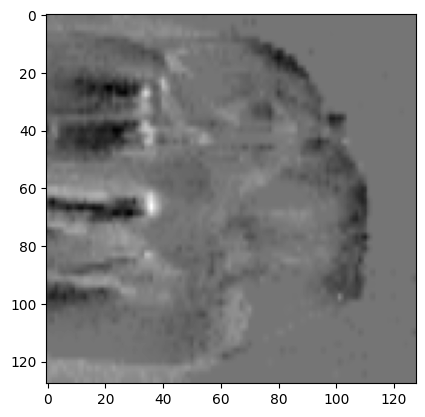

1


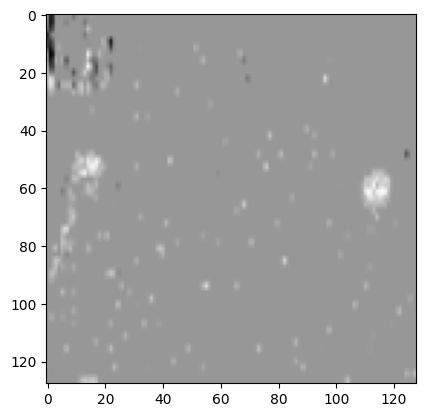

1


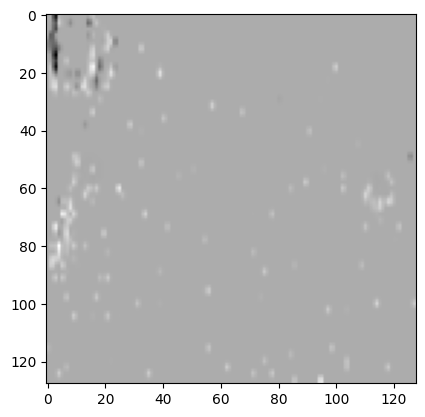

1


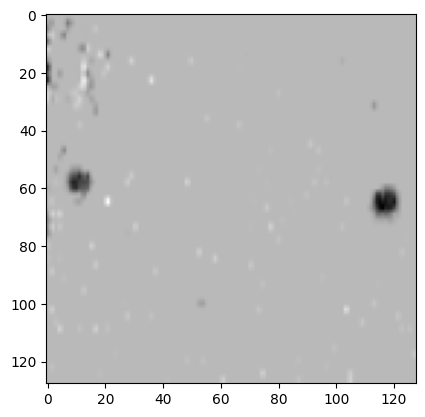

1


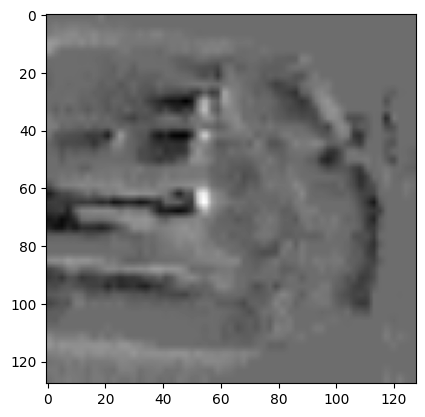

1


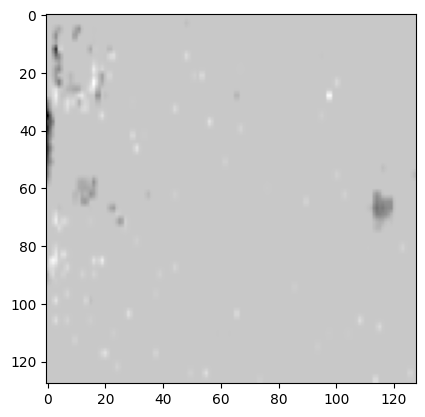

1


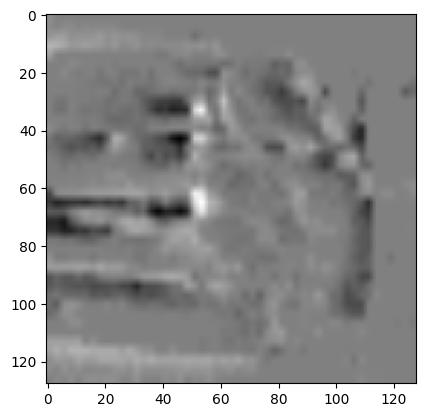

1


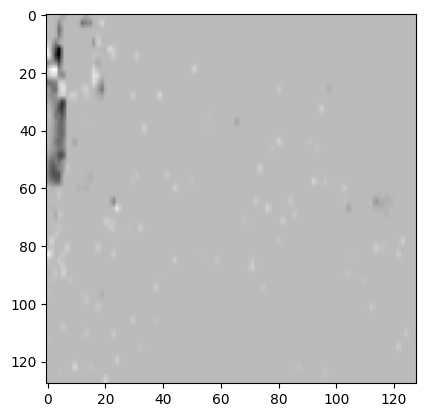

In [66]:
import matplotlib.pyplot as plt
for i in range(4000,4010):
    plt.imshow(train_x[i])
    print(train_y[i])
    plt.show()